<a href="https://colab.research.google.com/github/david-siqi-liu/cs684-final-project/blob/master/cs684_project_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Multi-Source Domain Adaption of Image Classification

Siqi Liu (20428295), Hoyoun Lee(20837711)

#Abstract

Typically, deep neural networks for image classification are trained and tested on images from the same domain. However, in the absence of larget amount of labelled data, it is often attractive to train using images from a different domain that is similar in nature.

In this VisDA 2019 challenge, we were tasked with building a classifier using images from a set of source domains, and testing it on images from a different target domain.

We used pre-trained ResNet50 as our starting point, and trained it as-is on the labelled source domain training sets. This benchmark model, when tested on the target domain test set, achieved a 85% accuracy score.

We then implemented various image augmentation techniques, and examined their effects on the accuracy score. Unfortunately, we were unable to get better resutls than our baseline, with the highest set of transformations yielding an accuracy score of 83%.

Lastly, we added a domain-confusion classifier (based on Ganin et al. 2014) in our model in an attempt to make the learned feature as indistinguishable as possible between the source and target domains. Unfortunately this also did not work, and our model ended up with a lower accuracy score of 71%.

#Introduction

Deep neural networks are usually trained on large amount of labelled data. However, in the absence of such abundance of data, it is often necessary to use labelled data of similar nature but from different domains, and train our network to be able to adapt and generalize the learned features. This approach however, suffers from the problem of a distribution shift, between the domains used for training (source) and the domain-of-interest (target).

In the VisDA 2019 challenge, we are given a set of images from multiple source domains (infograph, real, sketches, quickdraws) with 345 different labels, and asked to build a classifier for images from a target domain (clipart). Due to the lack of computing resources, we randomly selected 20 labels to train and test our models. We acknowledge that this would significantly increase our model accuracy compared to if we were to train and test using the entire dataset.

For start, we decided to use the pre-trained ResNet50 model in PyTorch since it was trained on the ImageNet data and has very good classification power. We trained it as-is on all labelled training images in the source domains, tested it using testing images in the target domains, and set the resulting accuracy score as our benchmark score.

After examining images under different domains, we realized that we could potentially help the network learn by transforming the images. Many related work had been done (Zhu et al. 2019) that showed positive effects image augmentations, especially transformations involving colour saturation, brightness and hue, on the model performance. Therefore, we experimented with many different combinations of image augmentations, and the set of that yielded the highest accuracy score is:

*   transforms.RandomRotation(5)
*   transforms.ColorJitter(brightness=0.3)
*   transforms.ColorJitter(contrast=0.3)
*   transforms.ColorJitter(saturation=0.3)
*   transforms.ColorJitter(hue=0.3)
*   transforms.RandomAffine(0, translate=(0.05,0.05))

Recognizing there are still large differences in the distributions between the source and target domains, we wanted to force the model to ignore the distribution shift and focus only on the objects. Our approach was to introduce another classifier, the domain classifier, in our model. This was first introduced by Ganin Y. and Lempitsky V. in their 2014 paper Unsupervised Domain Adaptation by Backpropagation.

![Proposed Architecture](https://miro.medium.com/max/3236/1*uDfooQ7EN9YdSRWM-PWeqw.png)

The figure above shows the architecture that Ganin and Lempitsky proposed. The feature extractor (green) and the label predictor (blue) forms the standard archtecture in image classification. Domain adaptaion is achieved by adding a domain classifier (red) that tries to predict which domain the image comes from based on the extracted features. As opposed to the classification loss in the label predictor ($L_y$), we treat this loss as a confusion loss ($L_d$). Essentially, we want our model to be confused about the domain, so it cannot create features that allow the domain classifier to work, but can still create features that allow the label predictor to work. To do this, we simply multiply $L_d$'s gradient by a negative constant during the backpropagation stage. Many technical details can be found in Model #3 section of the report.

The report below is structured as follows:

1.   Model #1 - Baseline model, ResNet50 as-is
2.   Model #2 - With image transformations
3.   Model #3 - With domain classifier

# Contribution


Siqi

1.   Data loading pipelines
2.   Implementing baseline model
3.   Implemented model #3 - with domain classifier

Hoyoun

1.   Implemented model #2 - with image augmentations
2.   Compiled and compared different run results
3.   Implemented model #3 - with domain classifier

# Transformation Results

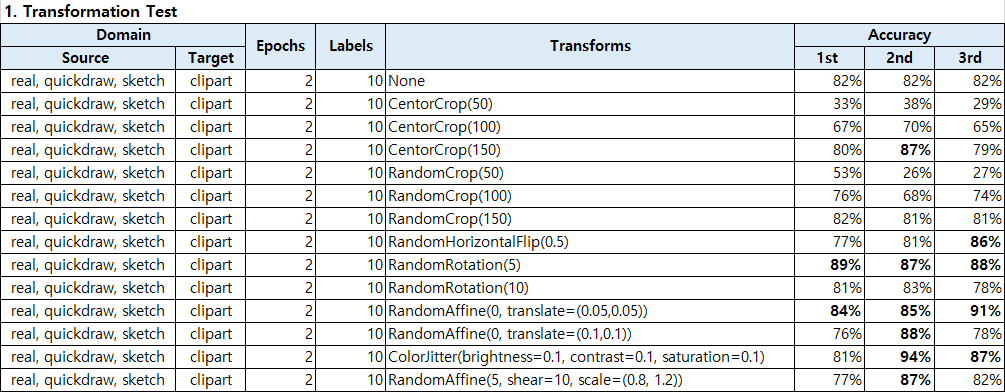

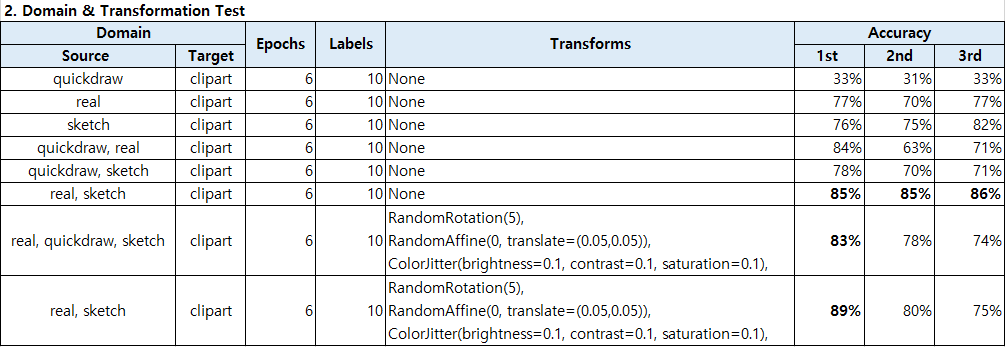

# Implementation

## Download Data

In [0]:
!rm -rf sample_data

In [0]:
from urllib.request import urlretrieve
import os
from zipfile import ZipFile

def download(url, file):
    if not os.path.isfile(file):
        urlretrieve(url, file)

#If the downloaded file is a zip file than you can use below function to unzip it.
def uncompress_features_labels(source, file, dest):
    if not os.path.isdir(file):
        with ZipFile(source) as zipf:
            zipf.extractall(dest)

'clipart.zip', 'infograph.zip', 'quickdraw.zip', 'real.zip', 'sketch.zip'

In [3]:
# Source images
for file in ['infograph.zip', 'quickdraw.zip', 'real.zip', 'sketch.zip']:
  download('http://csr.bu.edu/ftp/visda/2019/multi-source/' + file,
           file)
  print("Downloaded: {0}".format(file))
  uncompress_features_labels(file,
                             'data/' + file.split('.zip')[0],
                             'data/')
  print("Extracted: {0}".format(file))

Downloaded: infograph.zip
Extracted: infograph.zip
Downloaded: quickdraw.zip
Extracted: quickdraw.zip
Downloaded: real.zip
Extracted: real.zip
Downloaded: sketch.zip
Extracted: sketch.zip


In [4]:
# Target images (labelled)
download('http://csr.bu.edu/ftp/visda/2019/multi-source/groundtruth/clipart.zip', 'clipart.zip')
print("Downloaded: clipart.zip")
uncompress_features_labels('clipart.zip', 'data/clipart', 'data/')
print("Extracted: clipart.zip")

Downloaded: clipart.zip
Extracted: clipart.zip


In [0]:
!mkdir label

In [0]:
# Source labels
for file in ['infograph', 'quickdraw', 'real', 'sketch']:
  download('http://csr.bu.edu/ftp/visda/2019/multi-source/txt/' + file + '_train.txt',
           'label/' + file + '_train.txt')
  download('http://csr.bu.edu/ftp/visda/2019/multi-source/txt/' + file + '_test.txt',
           'label/' + file + '_test.txt')

In [0]:
# Target labels (groundtruth)
# For the training set, we will NOT look at their labels, so it's still unsupervised
download('http://csr.bu.edu/ftp/visda/2019/multi-source/groundtruth/txt/clipart_train.txt',
           'label/clipart_train.txt')
download('http://csr.bu.edu/ftp/visda/2019/multi-source/groundtruth/txt/clipart_test.txt',
           'label/clipart_test.txt')

## Import Packages

In [0]:
import os
import random
import pandas as pd
import numpy as np
import pylab as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
import torchvision.models as models
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from torch.autograd import Function
from PIL import Image, ImageColor
from time import time
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors)


In [0]:
USE_GPU = True

## Load Images and Labels

In total there are 345 labels. For this project, we randomly select 10 labels.

In [10]:
num_labels = 20

# Seed
manual_seed = 647
random.seed(manual_seed)
torch.manual_seed(manual_seed)

# Randomly select labels
selected_original_labels = random.sample(range(344), num_labels)
selected_original_labels.sort()

print("Selected labels: {0}".format(selected_original_labels))

# Create label mapping
label_to_original_mapping = {}
for i in range(0, num_labels):
  label_to_original_mapping[i] = selected_original_labels[i]
  
original_to_label_mapping = {v : k for k, v in label_to_original_mapping.items()}
print("Original to label mapping: {0}".format(original_to_label_mapping))
print("Label to original mapping: {0}".format(label_to_original_mapping))

# Find English term in target test file (since it's the smallest to load)
original_to_english_mapping = {}
for line in open("label/clipart_test.txt"):
  d = line.strip().split(' ')
  l = int(d[1])
  original_to_english_mapping[l] = d[0].split("/")[1]
  
print("Original to English mapping: {0}".format(original_to_english_mapping))

# Final label mapping
labels = {}
for i in range(0, num_labels):
  labels[i] = original_to_english_mapping[label_to_original_mapping[i]]

print("Labels: {0}".format(labels))

Selected labels: [21, 35, 48, 112, 115, 126, 132, 148, 169, 176, 177, 195, 220, 227, 245, 276, 314, 320, 332, 337]
Original to label mapping: {21: 0, 35: 1, 48: 2, 112: 3, 115: 4, 126: 5, 132: 6, 148: 7, 169: 8, 176: 9, 177: 10, 195: 11, 220: 12, 227: 13, 245: 14, 276: 15, 314: 16, 320: 17, 332: 18, 337: 19}
Label to original mapping: {0: 21, 1: 35, 2: 48, 3: 112, 4: 115, 5: 126, 6: 132, 7: 148, 8: 169, 9: 176, 10: 177, 11: 195, 12: 220, 13: 227, 14: 245, 15: 276, 16: 314, 17: 320, 18: 332, 19: 337}
Original to English mapping: {0: 'aircraft_carrier', 1: 'airplane', 2: 'alarm_clock', 3: 'ambulance', 4: 'angel', 5: 'animal_migration', 6: 'ant', 7: 'anvil', 8: 'apple', 9: 'arm', 10: 'asparagus', 11: 'axe', 12: 'backpack', 13: 'banana', 14: 'bandage', 15: 'barn', 16: 'baseball', 17: 'baseball_bat', 18: 'basket', 19: 'basketball', 20: 'bat', 21: 'bathtub', 22: 'beach', 23: 'bear', 24: 'beard', 25: 'bed', 26: 'bee', 27: 'belt', 28: 'bench', 29: 'bicycle', 30: 'binoculars', 31: 'bird', 32: '

In [0]:
###### LIST LOADER #######

def default_loader(path):
    """Default loader
    """
    return Image.open(path).convert('RGB')

def collect_images(img_dir, labels):
  """Return a list of (image path, label)

  Parameters:
  img_dir (String) : the directory containing the images
  labels (List[String]) : a list of labels (merged multiple sources together)

  Returns:
  List[(String, String)]
  """
  images = []
  indices = {}
  pos = 0
  for line in labels:
    data = line.strip().split(' ')
    path = os.path.join(img_dir, data[0])
    original_label = int(data[1])
    domain = int(data[2])
    # Among the labels selected
    if original_label in selected_original_labels:
      label = original_to_label_mapping[original_label]
      item = (path, label, domain)
      images.append(item)
      if label not in indices.keys():
        indices[label] = [pos]
      else:
        indices[label].append(pos)
      pos += 1
  return images, indices

class MyDataset(data.Dataset):
    """ Custom class for loading image list
    """
    def __init__(self, img_dir, labels, transform=None, loader=default_loader):
        imgs, indices = collect_images(img_dir, labels)
        self.img_dir = img_dir
        self.imgs = imgs
        self.indices = indices
        self.num_imgs = len(imgs)
        self.transform = transform
        self.loader = loader

    def __getitem__(self, index):
        path, label, domain = self.imgs[index]
        img = self.loader(path)

        if self.transform is not None:
            img = self.transform(img)
            
        return img, label, domain

    def __len__(self):
        return len(self.imgs)

    def get_random_sample_index(self, label, n=1):
      return np.random.choice(self.indices[label], n)[0]

In [0]:
###### IMAGE LOADER #######

batch_size_train = 56
batch_size_test = 24

def make_data_set(img_dir, label_dir, domain_list, transforms, source_or_target, train_or_test):
  labels = []
  if (source_or_target == 'source'):
    for d in range(len(domain_list)):
      # E.g. "label/infograph_test.txt"
      label_file = label_dir + domain_list[d] + '_' + train_or_test + '.txt'
      for line in open(label_file):
        # Space delimited
        # Source domain starts at 1
        labels.append(line + " {0}".format(d + 1))
  else:
    # E.g. "label/clipart_test.txt"
    label_file = label_dir + domain_list[0] + '_' + train_or_test + '.txt'
    for line in open(label_file):
        # Space delimited
        # Target domain is always 0
        labels.append(line + " 0")
  return MyDataset(img_dir, labels, transforms)

def make_data_loader(dataset, train_or_test):
  if (train_or_test == 'train'):
    return data.DataLoader(dataset, batch_size=batch_size_train,
                           shuffle=True, num_workers=4)
  else:
    return data.DataLoader(dataset, batch_size=batch_size_test,
                           shuffle=True, num_workers=4)

## Helper Functions

In [0]:
norm = ([0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225])

def tensor_to_PIL(img, mean, std):
  img = img.numpy().transpose((1, 2, 0))
  img = img * std + mean
  img = np.clip(img, 0, 1)
  return img

## Model Evaluation Metrics

In [0]:
def confusion_matrix(preds, targets, conf_matrix):
    preds = torch.argmax(preds, 1)
    for p, t in zip(preds, targets):
        conf_matrix[p, t] += 1

In [0]:
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):

    digits = datasets.load_digits(n_class=num_labels)

    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    pl.figure()
    ax = pl.subplot(111)
    for i in range(X.shape[0]):
        pl.text(X[i, 0], X[i, 1], str(digits.target[i]),
                color=pl.cm.Set1(y[i] / 10.),
                fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(np.shape(X)[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=pl.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    pl.xticks([]), pl.yticks([])
    if title is not None:
        pl.title(title)

In [0]:
def validate(val_loader, net, vis=True):
  
    conf_matrix = torch.zeros(num_labels, num_labels)
    net.eval()
    val_loss = 0
    correct = 0
    
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            
            inputs, target, domain = data

            if USE_GPU:
                inputs = inputs.cuda()
                target = target.cuda()
                domain = domain.cuda()
                net = net.cuda()

            output = net(inputs)[0]

            val_loss += F.nll_loss(output, target, reduction='mean').item()

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            confusion_matrix(output, target, conf_matrix)
   
    val_loss /= len(val_loader.dataset)


    if vis:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            val_loss, correct, len(val_loader.dataset),
           # float((num_labels ** 2) * correct / len(val_loader.dataset))))
            100. * correct / len(val_loader.dataset)))
        plt.title('Confusion Matrix')
        plt.imshow(conf_matrix, cmap='viridis', interpolation='nearest')
        plt.colorbar()
        plt.xticks(np.arange(num_labels), labels.values(), rotation='vertical')
        plt.yticks(np.arange(num_labels), labels.values())
        plt.show()
        
    net.train()
    return correct / len(val_loader.dataset)

## Data Loaders

In [0]:
home_dir = ''
img_dir = home_dir + 'data/'
label_dir = home_dir + 'label/'

source = ['quickdraw', 'real', 'sketch', 'infograph']
target = ['clipart']
num_source_domains = len(source)

img_size = 224

In [0]:
source_train_transforms = transforms.Compose([transforms.Resize([img_size, img_size]),
                                              transforms.ToTensor(),
                                              transforms.Normalize(*norm)])

source_test_transforms = transforms.Compose([transforms.Resize([img_size, img_size]),
                                             transforms.ToTensor(),
                                             transforms.Normalize(*norm)])

target_train_transforms = transforms.Compose([transforms.Resize([img_size, img_size]),
                                              transforms.ToTensor(),
                                              transforms.Normalize(*norm)])

target_test_transforms = transforms.Compose([transforms.Resize([img_size, img_size]),
                                             transforms.ToTensor(),
                                             transforms.Normalize(*norm)])

In [0]:
source_train_dataset = make_data_set(img_dir, label_dir, source, source_train_transforms, 'source', 'train')
source_train_dataloader = make_data_loader(source_train_dataset, 'train')

source_test_dataset = make_data_set(img_dir, label_dir, source, source_test_transforms, 'source', 'test')
source_test_dataloader = make_data_loader(source_test_dataset, 'test')

target_train_dataset = make_data_set(img_dir, label_dir, target, target_train_transforms, 'target', 'train')
target_train_dataloader = make_data_loader(target_train_dataset, 'train')

target_test_dataset = make_data_set(img_dir, label_dir, target, target_test_transforms, 'target', 'test')
target_test_dataloader = make_data_loader(target_test_dataset, 'test')

In [20]:
print("Source train dataset size: {0}".format(len(source_train_dataset)))
print("Source test dataset size: {0}".format(len(source_test_dataset)))
print("Target train dataset size: {0}".format(len(target_train_dataset)))
print("Target test dataset size: {0}".format(len(target_test_dataset)))

Source train dataset size: 20114
Source test dataset size: 8661
Target train dataset size: 1825
Target test dataset size: 795


## Sample Images

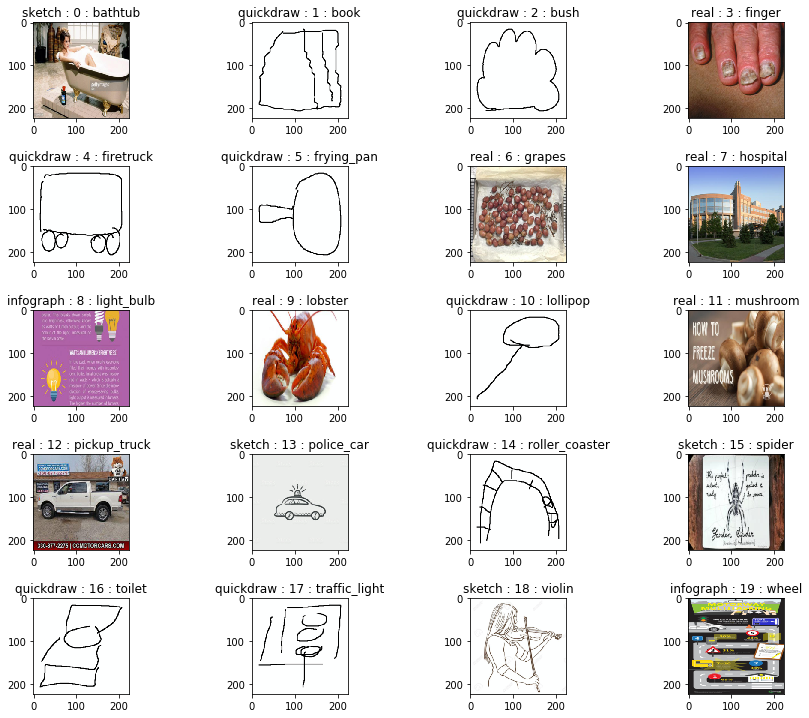

In [21]:
# Source training

fig = plt.figure(figsize=(15, 15))

plt.subplots_adjust(hspace=0.5)

for label, english in enumerate(labels.values()):
  index = source_train_dataset.get_random_sample_index(label)
  img, _, domain = source_train_dataset[index]
  ax1 = fig.add_subplot(num_labels/4+1, 4, label+1)
  plt.title("{0} : {1} : {2}".format(source[domain - 1], label, english))
  ax1.imshow(tensor_to_PIL(img, *norm))

plt.show()

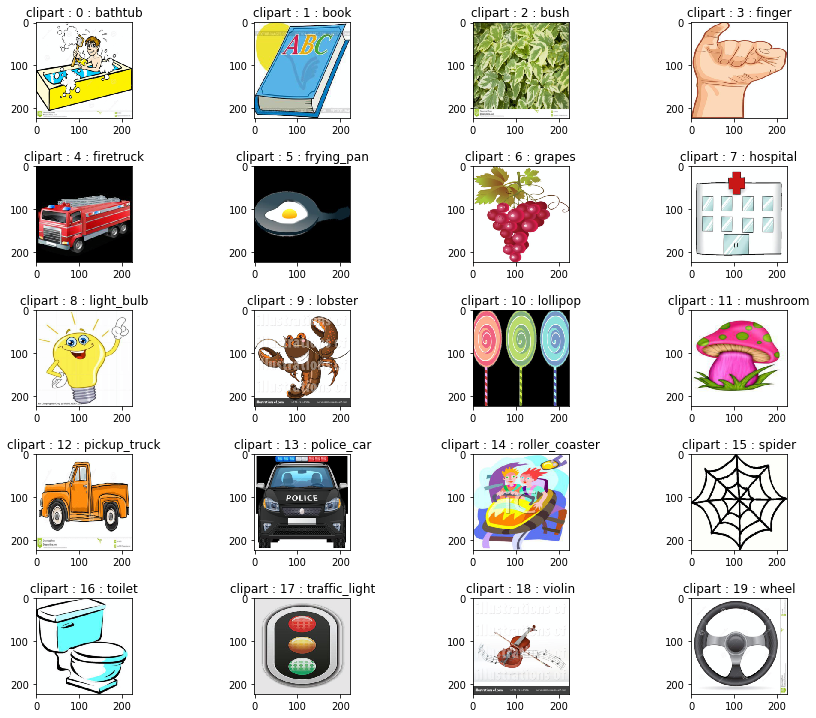

In [22]:
# Target test

fig = plt.figure(figsize=(15, 15))

plt.subplots_adjust(hspace=0.5)

for label, english in enumerate(labels.values()):
  index = target_test_dataset.get_random_sample_index(label)
  img, _, domain = target_test_dataset[index]
  ax1 = fig.add_subplot(num_labels/4+1, 4, label+1)
  plt.title("{0} : {1} : {2}".format(target[domain], label, english))
  ax1.imshow(tensor_to_PIL(img, *norm))

plt.show()

# Model #1 - Baseline

In [0]:
 debug = False
class Baseline(nn.Module):
    def __init__(self, num_classes):
        super(Baseline, self).__init__()
        # Transfer learning from ResNet50
        resnet = models.resnet50(pretrained = True)
        # Base layers
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        # ResNet layers
        self.res1 = resnet.layer1
        self.res2 = resnet.layer2
        self.res3 = resnet.layer3
        self.res4 = resnet.layer4
        # Classifier
        self.avgpool = resnet.avgpool
        self.fc = nn.Linear(2048, num_classes)
        
    def forward(self, x, gts=None):
        ### Encoders
        # Base layer
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = F.max_pool2d(out, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        # ResNet layers
        out = self.res1(out)
        out = self.res2(out)
        out = self.res3(out)
        out = self.res4(out)
        # Classifier
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        out = F.log_softmax(out, dim=1)

        return out, out

## Untrained

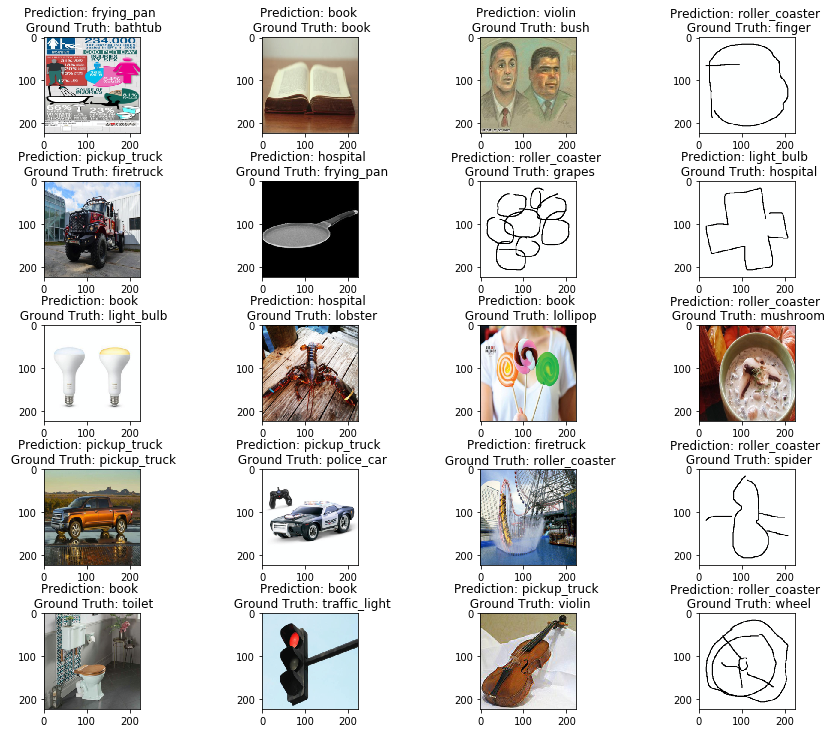

In [27]:
untrained_baseline = Baseline(num_labels).eval()

fig = plt.figure(figsize=(15, 15))

plt.subplots_adjust(hspace=0.5)

for label, english in enumerate(labels.values()):
  index = source_train_dataset.get_random_sample_index(label)
  img, _,_ = source_train_dataset[index]
  output = untrained_baseline.forward(img[None])[0]
  prediction = int(torch.argmax(output).numpy())
  ax1 = fig.add_subplot(num_labels/4+1, 4, label+1)
  plt.title("Prediction: {0} \n Ground Truth: {1}".format(labels[prediction], labels[label]))
  ax1.imshow(tensor_to_PIL(img, *norm))

plt.show()


Test set: Average loss: 0.0549, Accuracy: 1088/20114 (5%)



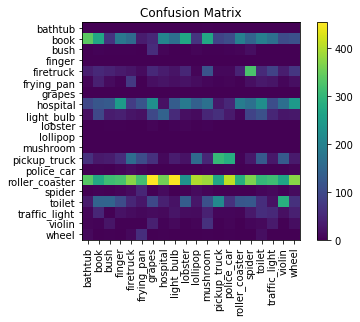

0.05409167743859998

In [28]:
validate(source_train_dataloader, untrained_baseline)

## Training

In [0]:
def get_optimizer(net):
    optimizer = torch.optim.SGD(net.parameters(),
                                lr=0.001,
                                weight_decay=1e-5,
                                momentum=0.5,
                                nesterov=False)
    return optimizer

In [0]:
# Training Loop

def train(train_loader, net, optimizer, loss_graph):
    
    for i, data in enumerate(train_loader):
        
        inputs, target, _ = data

        if USE_GPU:
            inputs = inputs.cuda()
            net = net.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        main_loss, main_loss2 = net(inputs, gts=target)
        loss = F.cross_entropy(main_loss,target) 
        loss_graph.append(loss.item())
        loss.backward()
        optimizer.step()

    return loss

360
Epoch: 0 Loss: 2.338383436203003
Epoch: 1 Loss: 0.9970943331718445
Epoch: 2 Loss: 1.935339331626892
Epoch: 3 Loss: 0.6300927996635437
Epoch: 4 Loss: 0.37957048416137695
Epoch: 5 Loss: 0.840330958366394
Epoch: 6 Loss: 1.0940359830856323
Epoch: 7 Loss: 0.5154762864112854
Epoch: 8 Loss: 0.8022881746292114
Epoch: 9 Loss: 0.17149576544761658


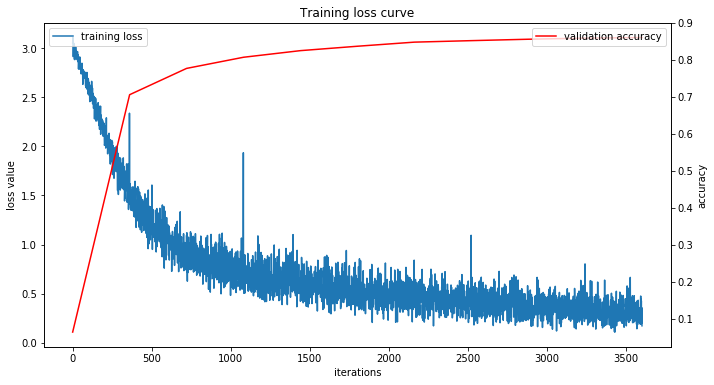

CPU times: user 13min 26s, sys: 7min 1s, total: 20min 28s
Wall time: 22min 42s


In [31]:
%%time

EPOCH = 10

net = Baseline(num_labels)
optimizer = get_optimizer(net)

print(len(source_train_dataloader))

loss_graph = []
val_idx = [0]
val_graph = []
val_graph.append(validate(source_test_dataloader, net, vis=False))
    
fig = plt.figure(figsize=(12,6))
plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
ax1 = fig.add_subplot(1,1,1)

ax2 = ax1.twinx()

for e in range(EPOCH):
    loss = train(source_train_dataloader, net, optimizer, loss_graph)
    
    val_idx.append((e + 1) * len(source_train_dataloader))
    val_graph.append(validate(source_test_dataloader, net, vis=False))
    ax1.clear()
    ax1.set_xlabel('iterations')
    ax1.set_ylabel('loss value')
    ax1.set_title('Training loss curve')
    ax1.plot(loss_graph, label='training loss')
    ax1.legend(loc='upper left')
    
    ax2.clear()
    ax2.set_ylabel('accuracy')
    ax2.plot(val_idx, val_graph, label='validation accuracy', color='red')
    ax2.legend(loc='upper right')
    print("Epoch: {} Loss: {}".format(e, loss))
    fig.canvas.draw()
  
plt.show()

## Evaluation

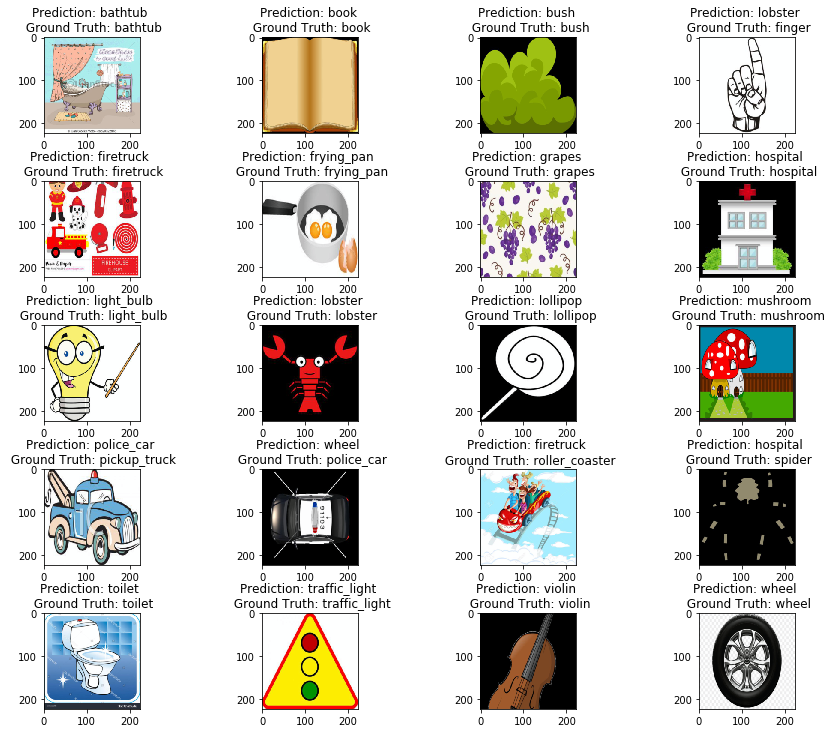

In [32]:
net = net.eval()

fig = plt.figure(figsize=(15, 15))

plt.subplots_adjust(hspace=0.5)

for label, english in enumerate(labels.values()):
  index = target_test_dataset.get_random_sample_index(label)
  img, _,_ = target_test_dataset[index]
  if USE_GPU:
      img = img.cuda()
      net = net.cuda()

  output = net.forward(img[None])[0]

  prediction = int(torch.argmax(output).cpu().numpy())

  ax1 = fig.add_subplot(num_labels/4+1, 4, label+1)
  plt.title("Prediction: {0} \n Ground Truth: {1}".format(labels[prediction], labels[label]))
  ax1.imshow(tensor_to_PIL(img.cpu(), *norm))

plt.show()


Test set: Average loss: 0.0230, Accuracy: 673/795 (85%)



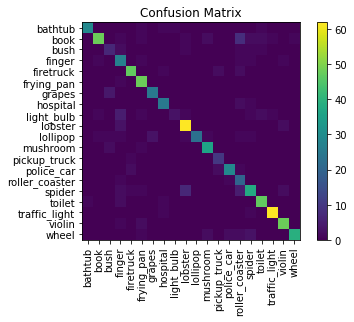

0.8465408805031447

In [33]:
validate(target_test_dataloader, net)

# Model #2 - With Image Transformations

## Modified data loaders

In [0]:
home_dir = ''
img_dir = home_dir + 'data/'
label_dir = home_dir + 'label/'

source = ['real','sketch','quickdraw', 'infograph' ]
target = ['clipart']
num_source_domains = len(source)

img_size = 224

In [0]:
source_train_transforms = transforms.Compose([transforms.Resize([img_size, img_size]),
                                              transforms.RandomRotation(5),
                                              transforms.ColorJitter(brightness=0.3),
                                              transforms.ColorJitter(contrast=0.3),
                                              transforms.ColorJitter(saturation=0.3),
                                              transforms.ColorJitter(hue=0.3),
                                              transforms.RandomAffine(0, translate=(0.05,0.05)),
                                              transforms.ToTensor(),
                                              transforms.Normalize(*norm)])

source_test_transforms = transforms.Compose([transforms.Resize([img_size, img_size]),
                                             transforms.ToTensor(),
                                             transforms.Normalize(*norm)])

target_train_transforms = transforms.Compose([transforms.Resize([img_size, img_size]),
                                              transforms.ToTensor(),
                                              transforms.Normalize(*norm)])

target_test_transforms = transforms.Compose([transforms.Resize([img_size, img_size]),
                                             transforms.ToTensor(),
                                             transforms.Normalize(*norm)])

In [0]:
source_train_dataset = make_data_set(img_dir, label_dir, source, source_train_transforms, 'source', 'train')
source_train_dataloader = make_data_loader(source_train_dataset, 'train')

source_test_dataset = make_data_set(img_dir, label_dir, source, source_test_transforms, 'source', 'test')
source_test_dataloader = make_data_loader(source_test_dataset, 'test')

target_train_dataset = make_data_set(img_dir, label_dir, target, target_train_transforms, 'target', 'train')
target_train_dataloader = make_data_loader(target_train_dataset, 'train')

target_test_dataset = make_data_set(img_dir, label_dir, target, target_test_transforms, 'target', 'test')
target_test_dataloader = make_data_loader(target_test_dataset, 'test')

In [37]:
print("Source train dataset size: {0}".format(len(source_train_dataset)))
print("Source test dataset size: {0}".format(len(source_test_dataset)))
print("Target train dataset size: {0}".format(len(target_train_dataset)))
print("Target test dataset size: {0}".format(len(target_test_dataset)))

Source train dataset size: 20114
Source test dataset size: 8661
Target train dataset size: 1825
Target test dataset size: 795


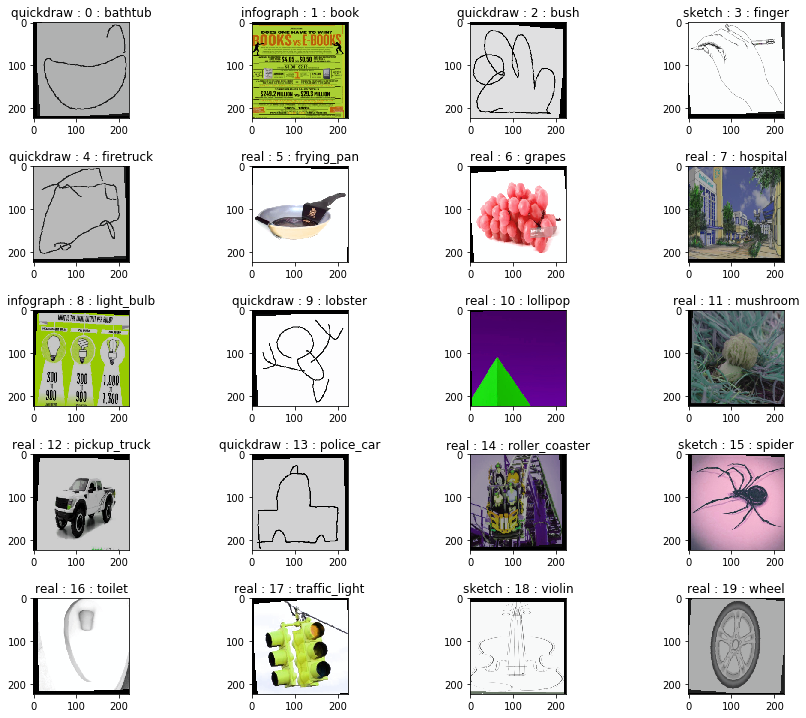

In [38]:
fig = plt.figure(figsize=(15, 15))

plt.subplots_adjust(hspace=0.5)

for label, english in enumerate(labels.values()):
  index = source_train_dataset.get_random_sample_index(label)
  img, _, domain = source_train_dataset[index]
  ax1 = fig.add_subplot(num_labels/4+1, 4, label+1)
  plt.title("{0} : {1} : {2}".format(source[domain - 1], label, english))
  ax1.imshow(tensor_to_PIL(img, *norm))

plt.show()

## Training

360
Epoch: 0 Loss: 2.1644504070281982
Epoch: 1 Loss: 1.173598051071167
Epoch: 2 Loss: 0.9818110466003418
Epoch: 3 Loss: 0.7593339681625366
Epoch: 4 Loss: 0.5594186782836914
Epoch: 5 Loss: 1.3205804824829102
Epoch: 6 Loss: 0.8525127172470093
Epoch: 7 Loss: 0.9871899485588074
Epoch: 8 Loss: 0.48241424560546875
Epoch: 9 Loss: 0.8409778475761414


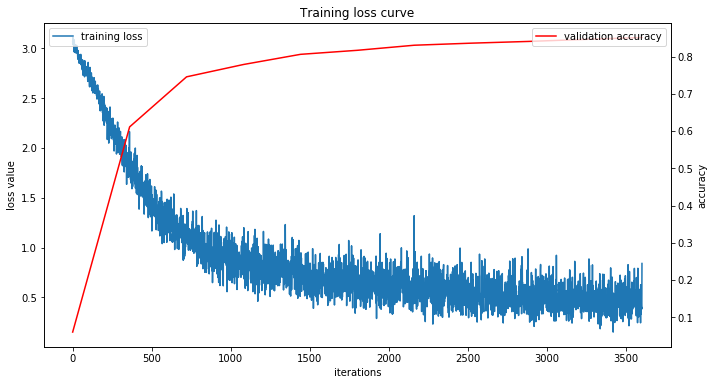

CPU times: user 13min 7s, sys: 5min 56s, total: 19min 4s
Wall time: 22min 55s


In [39]:
%%time

EPOCH = 10

net = Baseline(num_labels)
optimizer = get_optimizer(net)

print(len(source_train_dataloader))

loss_graph = []
val_idx = [0]
val_graph = []
val_graph.append(validate(source_test_dataloader, net, vis=False))
    
fig = plt.figure(figsize=(12,6))
plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
ax1 = fig.add_subplot(1,1,1)

ax2 = ax1.twinx()

for e in range(EPOCH):
    loss = train(source_train_dataloader, net, optimizer, loss_graph)
    
    val_idx.append((e + 1) * len(source_train_dataloader))
    val_graph.append(validate(source_test_dataloader, net, vis=False))
    ax1.clear()
    ax1.set_xlabel('iterations')
    ax1.set_ylabel('loss value')
    ax1.set_title('Training loss curve')
    ax1.plot(loss_graph, label='training loss')
    ax1.legend(loc='upper left')
    
    ax2.clear()
    ax2.set_ylabel('accuracy')
    ax2.plot(val_idx, val_graph, label='validation accuracy', color='red')
    ax2.legend(loc='upper right')
    print("Epoch: {} Loss: {}".format(e, loss))
    fig.canvas.draw()
  
plt.show()

## Evaluation

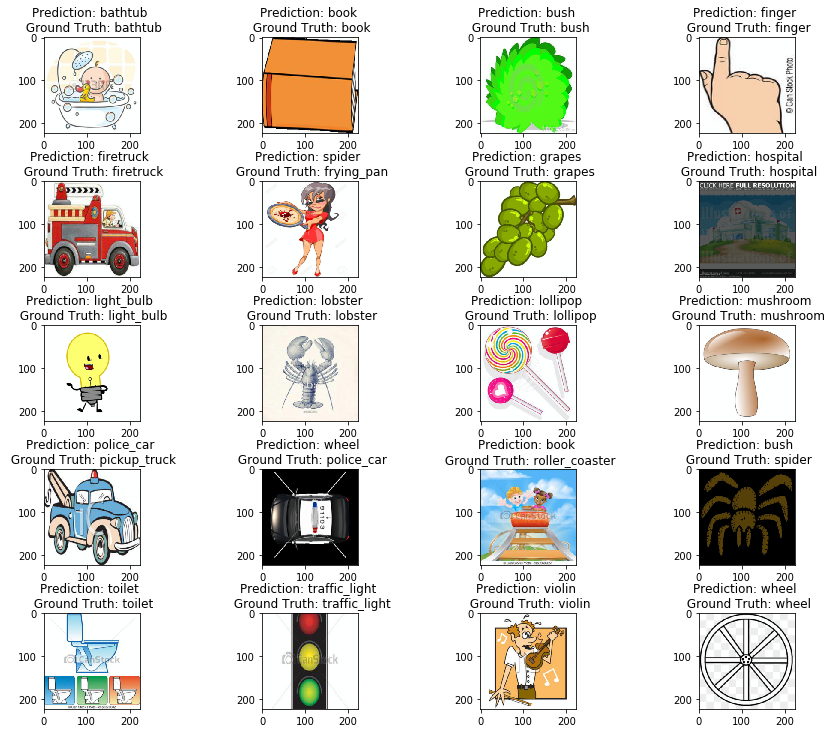

In [40]:
net = net.eval()

fig = plt.figure(figsize=(15, 15))

plt.subplots_adjust(hspace=0.5)

for label, english in enumerate(labels.values()):
  index = target_test_dataset.get_random_sample_index(label)
  img, _,_ = target_test_dataset[index]
  if USE_GPU:
      img = img.cuda()
      net = net.cuda()

  output = net.forward(img[None])[0]

  prediction = int(torch.argmax(output).cpu().numpy())

  ax1 = fig.add_subplot(num_labels/4+1, 4, label+1)
  plt.title("Prediction: {0} \n Ground Truth: {1}".format(labels[prediction], labels[label]))
  ax1.imshow(tensor_to_PIL(img.cpu(), *norm))

plt.show()


Test set: Average loss: 0.0234, Accuracy: 662/795 (83%)



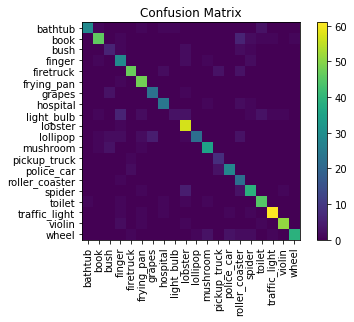

0.8327044025157233

In [41]:
validate(target_test_dataloader, net)

# Model #3 - With Domain Classifier

In [0]:
class ReverseLayerF(Function):

    @staticmethod
    def forward(ctx, x, alpha):
        # Store context for backward propagation
        ctx.alpha = alpha

        # Do nothing in forward pass
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        # Baskward pass is just to reverse (-alpha) the gradient
        output = grad_output.neg() * ctx.alpha

        # Must return same number as inputs to forward()
        return output, None

In [0]:
class DANN(nn.Module):
    def __init__(self, num_labels, num_source_domains):
        super(DANN, self).__init__()

        # Download pre-trained ResNet50
        resnet = models.resnet50(pretrained = True)

        ### Feature learning
        # Base layers
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        # ResNet layers
        self.res1 = resnet.layer1
        self.res2 = resnet.layer2
        self.res3 = resnet.layer3
        self.res4 = resnet.layer4
        # Average Pool
        self.avgpool = resnet.avgpool

        ### Class classifier
        self.class_fc1 = nn.Linear(2048, 100)
        self.class_bn1 = nn.BatchNorm1d(100)
        self.class_fc2 = nn.Linear(100, num_labels)

        ### Domain classifier
        self.domain_fc1 = nn.Linear(2048, 100)
        self.domain_bn1 = nn.BatchNorm1d(100)
        self.domain_fc2 = nn.Linear(100, num_source_domains + 1)
        
    def forward(self, x, alpha=1.0):
        ### Feature learning
        # Base layer
        feature = self.conv1(x)
        feature = self.bn1(feature)
        feature = F.relu(feature)
        feature = F.max_pool2d(feature, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        # ResNet layers
        feature = self.res1(feature)
        feature = self.res2(feature)
        feature = self.res3(feature)
        feature = self.res4(feature)
        feature = self.avgpool(feature)
        feature = torch.flatten(feature, 1)

        ### Class classifier
        class_output = self.class_fc1(feature)
        class_output = self.class_bn1(class_output)
        class_output = F.relu(class_output)
        class_output = self.class_fc2(class_output)
        class_output = F.log_softmax(class_output, dim=1)

        ### Domain classifier
        # Gradient reversal layer
        reverse_feature = ReverseLayerF.apply(feature, alpha)
        domain_output = self.domain_fc1(reverse_feature)
        domain_output = self.domain_bn1(domain_output)
        domain_output = F.relu(domain_output)
        domain_output = self.domain_fc2(domain_output)
        domain_output = F.log_softmax(domain_output, dim=1)

        return class_output, domain_output

In [0]:
# Initialie model
model = DANN(num_labels, num_source_domains)

## Optimizer

In [0]:
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 0.0001)

# optimizer = torch.optim.SGD(model.parameters(),
#                             lr=0.001,
#                             weight_decay=1e-5,
#                             momentum=0.5,
#                             nesterov=False)

loss_class = torch.nn.NLLLoss()
loss_domain = torch.nn.NLLLoss()

if USE_GPU:
    model = model.cuda()
    loss_class = loss_class.cuda()
    loss_domain = loss_domain.cuda()

for p in model.parameters():
    p.requires_grad = True

## Training

In [0]:
batch_size_train = 4
batch_size_test = 4

source_train_dataset = make_data_set(img_dir, label_dir, source, source_train_transforms, 'source', 'train')
source_train_dataloader = make_data_loader(source_train_dataset, 'train')

target_train_dataset = make_data_set(img_dir, label_dir, target, target_train_transforms, 'target', 'train')
target_train_dataloader = make_data_loader(target_train_dataset, 'train')

target_test_dataset = make_data_set(img_dir, label_dir, target, target_test_transforms, 'target', 'test')
target_test_dataloader = make_data_loader(target_test_dataset, 'test')

In [62]:
%%time
n_epoch = 10

# max_batches = min(len(source_train_dataloader), len(target_train_dataloader))
max_batches = len(source_train_dataloader)

# Train
for epoch_idx in range(n_epoch):
    print("Epoch {0} / {1}".format(epoch_idx + 1, n_epoch))
    
    source_data_iter = iter(source_train_dataloader)
    target_data_iter = iter(target_train_dataloader)

    for batch_idx in range(max_batches):
        # Reset optimizer's gradients
        optimizer.zero_grad()
        
        # Training progress
        p = float(batch_idx + epoch_idx * max_batches) / (n_epoch * max_batches)

        # Alpha for this batch
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        ### Source

        # Get source images, labels and domains
        s_img, s_label, s_domain = next(source_data_iter)

        if USE_GPU:
            s_img = s_img.cuda()
            s_label = s_label.cuda()
            s_domain = s_domain.cuda()

        # Forward pass
        label_pred, domain_pred = model(s_img, alpha)

        # Compute losses
        loss_s_label = loss_class(label_pred, s_label)
        loss_s_domain = loss_domain(domain_pred, s_domain)

        ### Target

        # Training on target domain
        # We don't compute the loss on label predictions
        try:
          t_img, _ , t_domain = next(target_data_iter)
        # Cycle
        except StopIteration:
          target_data_iter = iter(target_train_dataloader)
          t_img, _ , t_domain = next(target_data_iter)

        if USE_GPU:
            t_img = t_img.cuda()
            t_domain = t_domain.cuda()

        # Forward pass
        _, domain_pred = model(t_img, alpha)

        # Compute loss
        loss_t_domain = loss_domain(domain_pred, t_domain)

        ### Combined
        loss = loss_s_label + loss_s_domain + loss_t_domain

        # Backward pass
        loss.backward()
        optimizer.step()

        print ("\r",'[%d / %d], loss_s_label: %04.4f, loss_s_domain: %04.4f, loss_t_domain: %04.4f, alpha: %04.4f' \
              % (batch_idx + 1, max_batches, loss_s_label.data.cpu().numpy(),
                 loss_s_domain.data.cpu().numpy(), loss_t_domain.data.cpu().numpy(),
                 alpha),end="")
        
    print(' ')

print('done')

Epoch 1 / 10
 [360 / 360], loss_s_label: 0.9625, loss_s_domain: 1.9468, loss_t_domain: 0.6753, alpha: 0.4610 
Epoch 2 / 10
 [360 / 360], loss_s_label: 0.9159, loss_s_domain: 1.8883, loss_t_domain: 0.7143, alpha: 0.7610 
Epoch 3 / 10
 [360 / 360], loss_s_label: 0.3778, loss_s_domain: 2.0210, loss_t_domain: 0.7162, alpha: 0.9049 
Epoch 4 / 10
 [360 / 360], loss_s_label: 0.9153, loss_s_domain: 1.8986, loss_t_domain: 0.7032, alpha: 0.9639 
Epoch 5 / 10
 [360 / 360], loss_s_label: 1.2501, loss_s_domain: 2.0995, loss_t_domain: 0.6817, alpha: 0.9866 
Epoch 6 / 10
 [360 / 360], loss_s_label: 1.2967, loss_s_domain: 2.2130, loss_t_domain: 0.6833, alpha: 0.9950 
Epoch 7 / 10
 [360 / 360], loss_s_label: 0.2235, loss_s_domain: 2.1050, loss_t_domain: 0.6878, alpha: 0.9982 
Epoch 8 / 10
 [360 / 360], loss_s_label: 1.1333, loss_s_domain: 1.9469, loss_t_domain: 0.6986, alpha: 0.9993 
Epoch 9 / 10
 [360 / 360], loss_s_label: 0.2451, loss_s_domain: 2.0332, loss_t_domain: 0.6932, alpha: 0.9998 
Epoch 10 /

## Evaluation


Test set: Average loss: 0.0504, Accuracy: 566/795 (71%)



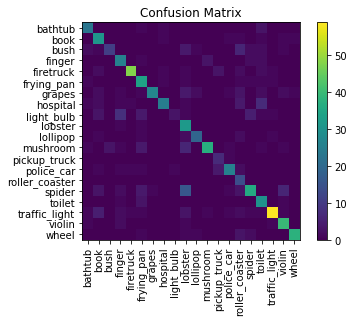

0.7119496855345911

In [63]:
validate(target_test_dataloader, model)

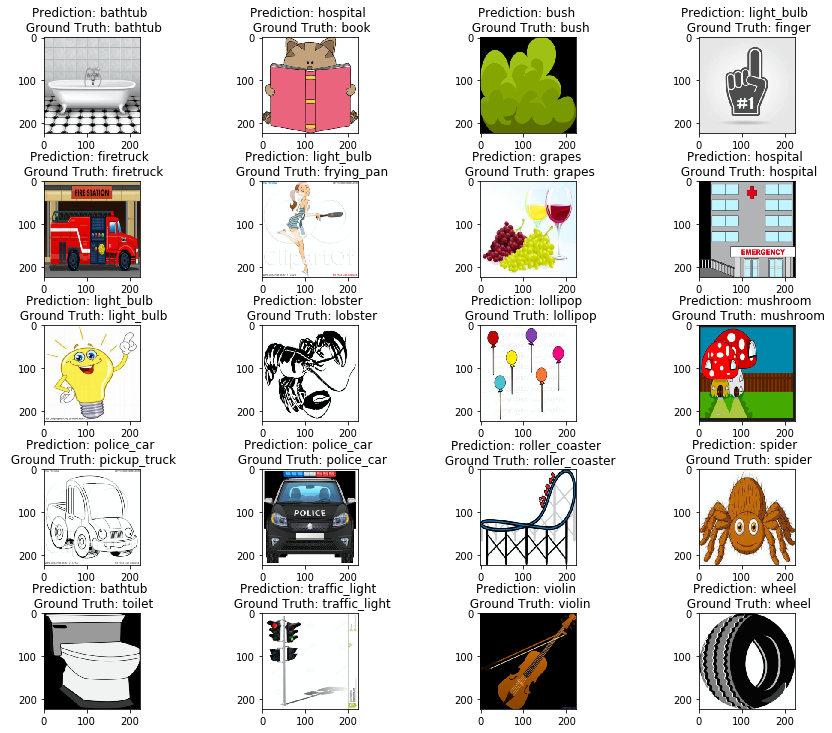

In [64]:
model = model.eval()

fig = plt.figure(figsize=(15, 15))

plt.subplots_adjust(hspace=0.5)

for label, english in enumerate(labels.values()):
  index = target_test_dataset.get_random_sample_index(label)
  img, _, domain = target_test_dataset[index]
  if USE_GPU:
      img = img.cuda()
      model = model.cuda()

  output = model.forward(img[None])[0]

  prediction = int(torch.argmax(output).cpu().numpy())

  ax1 = fig.add_subplot(num_labels/4+1, 4, label+1)
  plt.title("Prediction: {0} \n Ground Truth: {1}".format(labels[prediction], labels[label]))
  ax1.imshow(tensor_to_PIL(img.cpu(), *norm))

plt.show()

# Conclusion

Unfortunately, both of our approaches in trying to make the model performance better did not succeed.

When we applied transformations to our training dataset, not only didn't it improve the result, the accuracy score actually decreased. This is discouraging because we had thought, by randomly changing different aspects of its colour and applying random affine transformations we would be able to add variaties in our training data, thus yielding higher prediction power. We believe that this decrease in accuracy is due to a combination of lack of data, and too large of distribution difference even among source domains.

Similarly, implementing the domain classifier also brought down our model prediction accuracy. We believe there are several factors at play:

1.   In the original paper, only 1 source domain and 1 target domain was investigated, so it's unclear whether if the same approach would work with 4 source domains and 1 target domain
2.   The original paper used AlexNet as its baseline, so it is likely that ResNet50, which is a much more recent model, is far more superior than AlexNet that the addition of domain classifier simply does not add any value
3.   There's an uneven number (almost 10 times more) of labelled source training data than unlabelled target training data, so we had to repeatedly use the unlabelled target training data in an epoch. Ideally, we should have an even number of data so the classifier can learn efficiently

However, we believe that the theoretical intuition behind the domain adaptaion framework is sound. There are many other related-work in this exciting field of research that we are yet to explore.